# IMDB Reviews Classification with Bidirectional LSTM

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the data

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Tokenizing and data preprocessing

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [5]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())
  
for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? b'a very close and sharp <OOV> of the <OOV> and dynamic emotional world of <OOV> one <OOV> old guy that makes his first experiences in his gay love to an other boy during an vacation with a part of his family br br i liked this film because of his <OOV> clear and <OOV> storytelling with all this sound close ups and quiet moments <OOV> had been full of <OOV> <OOV> br br '
b'A very close and sharp discription of the bubbling and dynamic emotional world of specialy one 18year old guy, that makes his first experiences in his gay love to an other boy, during an vacation with a part of his family.<br /><br />I liked this film because of his extremly clear and surrogated storytelling , with all this "Sound-close-ups" and quiet moments wich had been full of intensive moods.<br /><br />'


## Defining the Bidirectional LSTM model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [9]:
with tf.device('/device:GPU:0'):
    history = model.fit(padded, training_labels_final, epochs=10, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
25000/25000 [==============================] - 857s 34ms/sample - loss: 0.4801 - acc: 0.7505 - val_loss: 0.3469 - val_acc: 0.8548
Epoch 2/10
25000/25000 [==============================] - 853s 34ms/sample - loss: 0.2940 - acc: 0.8800 - val_loss: 0.3466 - val_acc: 0.8494
Epoch 3/10
25000/25000 [==============================] - 853s 34ms/sample - loss: 0.2323 - acc: 0.9096 - val_loss: 0.3914 - val_acc: 0.8277
Epoch 4/10
25000/25000 [==============================] - 858s 34ms/sample - loss: 0.1886 - acc: 0.9287 - val_loss: 0.4153 - val_acc: 0.8343
Epoch 5/10
25000/25000 [==============================] - 859s 34ms/sample - loss: 0.1467 - acc: 0.9483 - val_loss: 0.5024 - val_acc: 0.8323
Epoch 6/10
25000/25000 [==============================] - 871s 35ms/sample - loss: 0.1141 - acc: 0.9592 - val_loss: 0.5840 - val_acc: 0.8260
Epoch 7/10
25000/25000 [==============================] - 871s 35ms/sample - loss: 0.0914 - acc: 0.9687 - val_loss: 0.7704 - val_acc: 0.8209
Epoch 8/10
25

## Visualizing the results

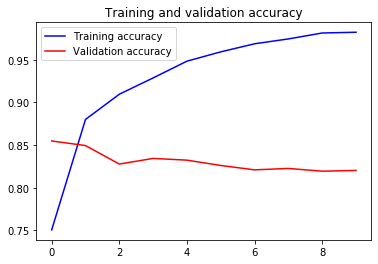

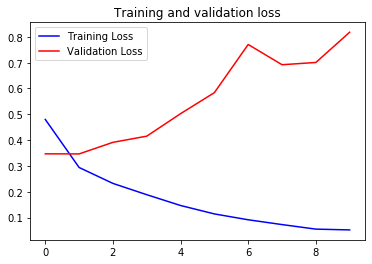

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()